In [107]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [108]:
# Necessary utility modules and libraries
import os
import shutil
import pathlib
import random
import datetime

# Plotting libraries 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Libraries for building the model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [109]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.applications import DenseNet121, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import cohen_kappa_score

In [110]:
root_dir = r'C:\Users\SAi Priya\Downloads\archive (2) - Copy\gaussian_filtered_images\gaussian_filtered_images'
classes = os.listdir(root_dir)
#classes.pop(0)
classes

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [111]:
# Walk through gaussian_filtered_images directory and list names of files
for dirpath, dirnames, filenames in os.walk(root_dir):
    print(f"There are {len(filenames)} images in {dirpath.split('/')[-1]}")

There are 0 images in C:\Users\SAi Priya\Downloads\archive (2) - Copy\gaussian_filtered_images\gaussian_filtered_images
There are 370 images in C:\Users\SAi Priya\Downloads\archive (2) - Copy\gaussian_filtered_images\gaussian_filtered_images\Mild
There are 999 images in C:\Users\SAi Priya\Downloads\archive (2) - Copy\gaussian_filtered_images\gaussian_filtered_images\Moderate
There are 1805 images in C:\Users\SAi Priya\Downloads\archive (2) - Copy\gaussian_filtered_images\gaussian_filtered_images\No_DR
There are 295 images in C:\Users\SAi Priya\Downloads\archive (2) - Copy\gaussian_filtered_images\gaussian_filtered_images\Proliferate_DR
There are 193 images in C:\Users\SAi Priya\Downloads\archive (2) - Copy\gaussian_filtered_images\gaussian_filtered_images\Severe


In [112]:
# View random images in the dataset
def view_random_images(root_dir=root_dir, classes=classes):
    class_paths = [root_dir + "/" + image_class for image_class in classes]
    # print(class_paths)
    images_path = []
    labels = []
    for i in range(len(class_paths)):
        random_images = random.sample(os.listdir(class_paths[i]), 10)
        random_images_path = [class_paths[i]+'/'+img for img in random_images]
        for j in random_images_path:
            images_path.append(j)
            labels.append(classes[i])
    images_path

    plt.figure(figsize=(17, 10))
    plt.suptitle("Image Dataset", fontsize=20)

    for i in range(1, 51):
        plt.subplot(5, 10, i)
        img = mpimg.imread(images_path[i-1])
        plt.imshow(img, aspect="auto")
        plt.title(labels[i-1])
        plt.axis(False);

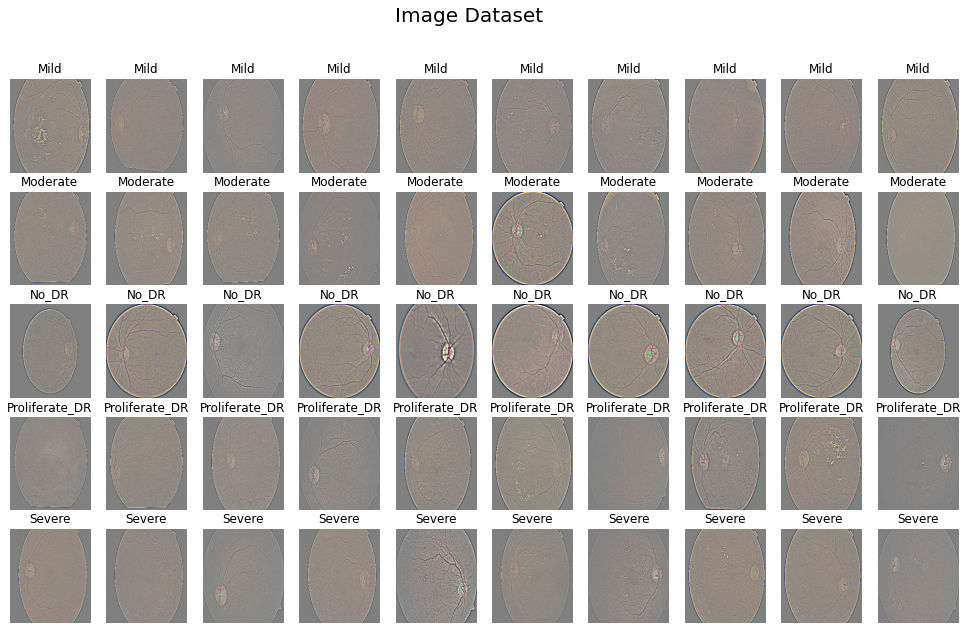

In [113]:
# Observing the images
view_random_images()

In [114]:
train_csv = pd.read_csv(r"C:\Users\SAi Priya\Downloads\archive (2) - Copy\train.csv")
train_csv

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [115]:
train_csv['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [116]:
train_df = {}
test_df = {}
for i in range(5):
    df = train_csv[train_csv['diagnosis']==i]['id_code'].to_list()
    for j in random.sample(df, int(0.8*len(df))):
        train_df[j] = i
    for j in df:
        if j not in train_df.keys():
            test_df[j] = i
train_df = pd.DataFrame(train_df.items(), columns=['id_code', 'diagnosis']).sample(frac=1, random_state=42)
test_df = pd.DataFrame(test_df.items(), columns=['id_code', 'diagnosis']).sample(frac=1, random_state=42)
train_df

,id_code,diagnosis
1472,cd5714db652d,1
2178,c5431b81cbc9,2
368,bc7bf19b84e3,0
2614,7d3835e4e63a,3
1818,8d7bb0649a02,2
...,...,...
1638,27e4c800a449,1
1095,91f3c4c1e72b,0
1130,74211a2b6dcf,0
1294,71e43b4f8ba6,0


In [117]:
def mapping(df):
    class_code = {0: "No_DR",
                  1: "Mild", 
                  2: "Moderate",
                  3: "Severe",
                  4: "Proliferate_DR"}
    df['label'] = list(map(class_code.get, df['diagnosis']))
    df['path'] = [i[1]['label']+'/'+i[1]['id_code']+'.png' for i in df.iterrows()]
    return df

In [118]:
mapping(train_df), mapping(test_df)

(           id_code  diagnosis     label                       path
 1472  cd5714db652d          1      Mild      Mild/cd5714db652d.png
 2178  c5431b81cbc9          2  Moderate  Moderate/c5431b81cbc9.png
 368   bc7bf19b84e3          0     No_DR     No_DR/bc7bf19b84e3.png
 2614  7d3835e4e63a          3    Severe    Severe/7d3835e4e63a.png
 1818  8d7bb0649a02          2  Moderate  Moderate/8d7bb0649a02.png
 ...            ...        ...       ...                        ...
 1638  27e4c800a449          1      Mild      Mild/27e4c800a449.png
 1095  91f3c4c1e72b          0     No_DR     No_DR/91f3c4c1e72b.png
 1130  74211a2b6dcf          0     No_DR     No_DR/74211a2b6dcf.png
 1294  71e43b4f8ba6          0     No_DR     No_DR/71e43b4f8ba6.png
 860   cae33655ca00          0     No_DR     No_DR/cae33655ca00.png
 
 [2929 rows x 4 columns],
           id_code  diagnosis     label                       path
 666  a8e88d4891c4          3    Severe    Severe/a8e88d4891c4.png
 33   1ca91751be4d    

In [119]:
len(train_df), len(test_df)

(2929, 733)

In [120]:
# Initializing the input size
IMG_SHAPE = (224, 224)
N_SPLIT = 5
EPOCHS = 15

In [121]:
# Function to perform k-fold validation on test model
def validation_k_fold(model_test, k=5, epochs=EPOCHS, n_splits=N_SPLIT, lr=0.001): 
    kfold = StratifiedKFold(n_splits=N_SPLIT,shuffle=True,random_state=42)
    train_datagen = ImageDataGenerator(rescale = 1./255)
    validation_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen = ImageDataGenerator(rescale= 1./255)

    train_y = train_df['label']
    train_x = train_df['path']

    # Variable for keeping the count of the splits we're executing
    j = 0
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    for train_idx, val_idx in list(kfold.split(train_x,train_y)):
        x_train_df = train_df.iloc[train_idx]
        x_valid_df = train_df.iloc[val_idx]
        j+=1
        train_data = train_datagen.flow_from_dataframe(dataframe=x_train_df, 
                                                       directory=root_dir,
                                                       x_col='path',
                                                       y_col='label',
                                                       class_mode="categorical",
                                                       target_size=IMG_SHAPE)

        valid_data = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, 
                                                           directory=root_dir,
                                                           x_col='path',
                                                           y_col='label',
                                                           class_mode="categorical",
                                                           target_size=IMG_SHAPE)
                
        test_data = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                                   directory=root_dir,
                                                   x_col='path',
                                                   y_col='label',
                                                   class_mode="categorical",
                                                   target_size=IMG_SHAPE)
        
        # Initializing the early stopping callback
        es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        
        # Compile the model
        model_test.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adamax(learning_rate=lr),
                              metrics=['accuracy'])
        history = model_test.fit_generator(train_data,
                                           validation_data=valid_data,
                                           epochs=epochs,
                                           validation_steps=len(valid_data),
                                           callbacks=[es])
        # Evaluate the model
        result = model_test.evaluate(test_data)
        model_test_result = {
            "test_loss": result[0],
            "test_accuracy": result[1],
        }
        y_pred = model_test.predict(test_data)
        return [history, model_test_result, y_pred, test_data.classes]

In [122]:
# Function to plot the performance metrics
def plot_result(hist):
    plt.figure(figsize=(10, 7));
    plt.suptitle(f"Performance Metrics", fontsize=20)
    
    # Actual and validation losses
    plt.subplot(2, 2, 1);
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.title('Train and validation loss curve')
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(2, 2, 2);
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.title('Training and validation accuracy curve')
    plt.legend()

In [123]:
# Basic CNN model
model_cnn = tf.keras.Sequential([
    Conv2D(input_shape=IMG_SHAPE+(3,), filters=8,kernel_size=3,strides=4,activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
      
    Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
    
    Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
 
    Flatten(),
    Dense(32, activation = 'relu'),
    Dropout(0.15),
    Dense(len(classes), activation = 'softmax')
], name="model_cnn")

In [124]:
# Summary of cnn model
model_cnn.summary()
model_cnn_history, model_cnn_result, model_cnn_pred, y_test = validation_k_fold(model_cnn, lr=0.001)

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 56, 56, 8)         224       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 28, 28, 8)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 16)        1168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                         

C:\Users\SAi Priya\AppData\Local\Temp\ipykernel_8160\2999258808.py:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_test.fit_generator(train_data,


Epoch 1/15
74/74 [==============================] - 16s 203ms/step - loss: 1.0042 - accuracy: 0.6440 - val_loss: 1.4041 - val_accuracy: 0.4932
Epoch 2/15
74/74 [==============================] - 14s 187ms/step - loss: 0.8107 - accuracy: 0.7230 - val_loss: 1.2822 - val_accuracy: 0.4932
Epoch 3/15
74/74 [==============================] - 14s 190ms/step - loss: 0.7405 - accuracy: 0.7350 - val_loss: 1.2048 - val_accuracy: 0.4932
Epoch 4/15
74/74 [==============================] - 14s 186ms/step - loss: 0.6850 - accuracy: 0.7571 - val_loss: 1.1381 - val_accuracy: 0.5000
Epoch 5/15
74/74 [==============================] - 14s 188ms/step - loss: 0.6300 - accuracy: 0.7772 - val_loss: 1.1620 - val_accuracy: 0.4966
Epoch 6/15
74/74 [==============================] - 14s 189ms/step - loss: 0.5863 - accuracy: 0.7904 - val_loss: 1.0029 - val_accuracy: 0.6143
Epoch 7/15
74/74 [==============================] - 14s 187ms/step - loss: 0.5528 - accuracy: 0.7998 - val_loss: 0.8677 - val_accuracy: 0.6638

In [125]:
# Evaluation metrics for alexnet
model_cnn_result

{'test_loss': 0.8069573640823364, 'test_accuracy': 0.7121418714523315}

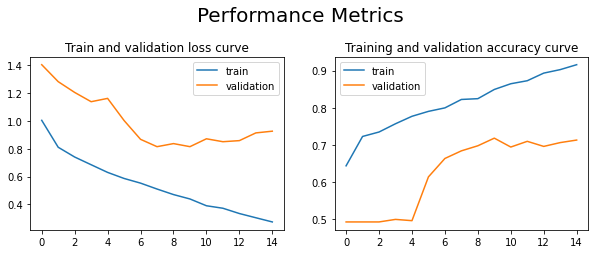

In [126]:
# Performance metrics for AlexNet
plot_result(model_cnn_history)

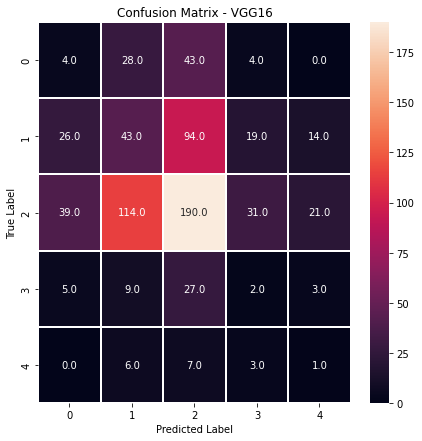

In [127]:
y_pred_cnn = np.argmax(model_cnn_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred_cnn, y_test)
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
patient_labels = ['0','1','2','3','4']
ax.yaxis.set_ticklabels(patient_labels)
plt.title("Confusion Matrix - VGG16")
plt.show()

In [128]:
print(classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.05      0.05      0.05        74
           1       0.22      0.21      0.22       200
           2       0.48      0.53      0.50       361
           3       0.04      0.03      0.04        59
           4       0.06      0.03      0.04        39

    accuracy                           0.33       733
   macro avg       0.17      0.17      0.17       733
weighted avg       0.31      0.33      0.32       733



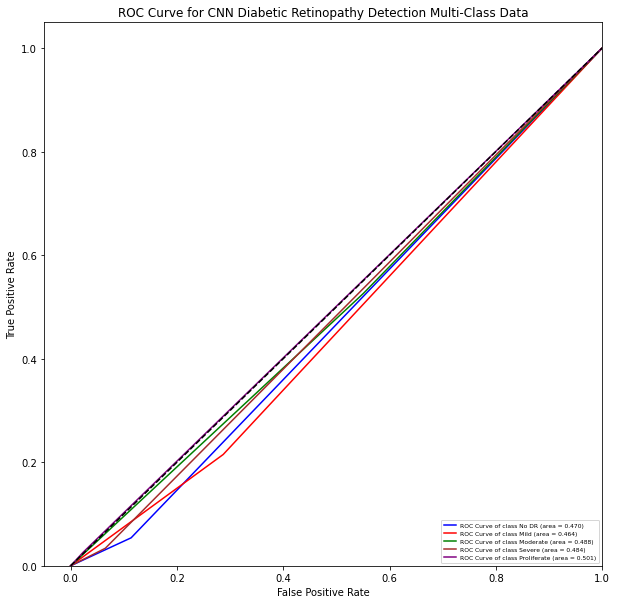

In [129]:
class_labels = ['No DR','Mild','Moderate','Severe','Proliferate']
y_score = label_binarize(y_pred_cnn, classes = [0,1,2,3,4])
ytest_binary = label_binarize(y_test, classes = [0,1,2,3,4]) # one hot encode the test data true labels
n_classes = y_score.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict() 
# compute fpr and tpr with roc_curve from the ytest true labels to the scores
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest_binary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot each class  curve on single graph for multi-class one vs all classification
f,ax = plt.subplots(figsize=(10, 10))
colors = ['blue', 'red', 'green', 'brown', 'purple']
for i, color, lbl in zip(range(n_classes), colors, class_labels):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN Diabetic Retinopathy Detection Multi-Class Data')
plt.legend(loc = 'lower right', prop = {'size': 6})
plt.show()

In [130]:
def pred_vals(model_history):
    d = {}
    d['acc'] = np.mean(model_history.history['accuracy'])
    d['val_acc'] = np.mean(model_history.history['val_accuracy'])
    return d 

In [131]:
df_result = pd.DataFrame({'CNN': pred_vals(model_cnn_history)}).transpose()
df_result = df_result.reset_index().rename(columns={'index': 'model'})
df_result

,model,acc,val_acc
0,CNN,0.811495,0.625028


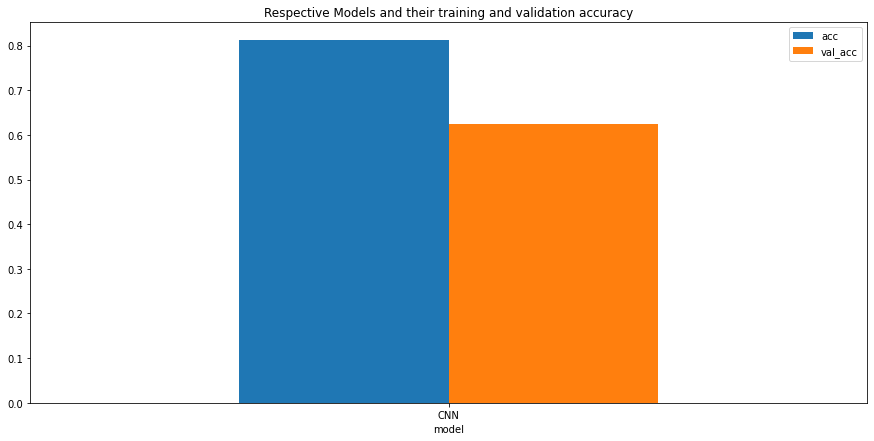

In [132]:
# plt.style.use('seaborn')
# Plotting models and their accuracy performance
df_result.plot(x='model', y=['acc', 'val_acc'], kind='bar', figsize=(15, 7))
plt.xticks(rotation=0)
plt.title('Respective Models and their training and validation accuracy');